# 📈 **Sales Prediction Model Development**

## **🎯 Objective**
Develop a robust sales prediction model for Rossmann Pharmaceuticals to forecast daily sales across stores.

## **🛠️ Approach**

### **1️⃣ Data Preprocessing**
- **Handle Missing Values**: Impute or remove missing data.
- **Outlier Detection**: Identify and manage outliers.
- **Feature Scaling**: Normalize or standardize features.

### **2️⃣ Feature Engineering**
- **Create Features**: Extract time-based features (day, month, holidays) and lagged sales data.
- **Feature Selection**: Use correlation analysis and feature importance scores.

### **3️⃣ Model Development**
- **Model Selection**: Compare algorithms like Linear Regression, Random Forest, and LSTM.
- **Model Training**: Split data into training/validation sets and tune hyperparameters.

### **4️⃣ Model Evaluation**
- **Performance Metrics**: Use MAE, RMSE, and R-squared for evaluation.
- **Validation**: Ensure the model generalizes well on unseen data.

### **5️⃣ Prediction and Insights**
- **Sales Forecasting**: Generate predictions for the next six weeks.
- **Actionable Insights**: Summarize findings and recommendations.

## **✅ Summary of Steps**
1. Preprocess data.
2. Engineer features.
3. Train models.
4. Evaluate performance.
5. Generate forecasts and insights.

<style>
    h1 {
        color: #aaee99;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h1>✨ Preprocessing ✨</h1>


In [1]:
import logging

# Configure logging
logging.basicConfig(
    filename="predictive.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger()

# Example log
logger.info("Logging setup complete.")


<style>
    h2 {
        color: #ffaa00;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h2>✨ Import Modules ✨</h1>


In [2]:
! pip install tensorflow

In [3]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
import sys
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))
sys.path.append(os.path.abspath('../scripts'))

from scripts.Data_preprocessing_pipline import DataPreprocessingPipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import logging
import warnings
import os
import pickle
from datetime import datetime

<style>
    h2 {
        color: #ffaa00;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h2>✨ Load and Preview Data ✨</h1>


In [3]:
# File paths
train_path = r'C:\Users\fikad\Desktop\10acedamy\Rossmann-Pharmaceuticals-Sales-Prediction\Data\train.csv'
test_path = r'C:\Users\fikad\Desktop\10acedamy\Rossmann-Pharmaceuticals-Sales-Prediction\Data\test.csv'
store_path = r'C:\Users\fikad\Desktop\10acedamy\Rossmann-Pharmaceuticals-Sales-Prediction\Data\store.csv'

# Data loading our data is in CSV format
train = pd.read_csv(train_path)
test= pd.read_csv(test_path)
store = pd.read_csv(store_path)


C:\Users\fikad\AppData\Local\Temp\ipykernel_21340\1267427687.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


In [5]:
print("Train columns:", train.columns)
print("Test columns:", test.columns)

Train columns: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')
Test columns: Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


 
<style>
    h2 {
        color: #ffaa00;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h2>✨ Building a Data Preprocessing Pipeline for Sales Prediction ✨</h1>

In [4]:
pipeline = DataPreprocessingPipeline(train, test, store)


In [5]:
processed_train, processed_test = pipeline.run_pipeline(
    missing_num_strategy='mean',
    missing_cat_strategy='mode',
    outlier_method='zscore'
)

c:\Users\fikad\Desktop\DESKTOP\Rossmann-Pharmaceuticals-Sales-Prediction\scripts\Data_preprocessing_pipline.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value.iloc[0], inplace=True)
c:\Users\fikad\Desktop\DESKTOP\Rossmann-Pharmaceuticals-Sales-Prediction\scripts\Data_preprocessing_pipline.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work

In [8]:
processed_train.columns


Index(['Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Weekday', 'IsWeekend', 'Day',
       'Month', 'Year', 'IsHoliday', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_b', 'Assortment_c'],
      dtype='object')

In [10]:
processed_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Weekday', 'IsWeekend', 'Day',
       'Month', 'Year', 'IsHoliday', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_b', 'Assortment_c'],
      dtype='object')

In [11]:
processed_train.head()

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,IsWeekend,Day,Month,Year,IsHoliday,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,5,5263,1,1,1,1270.0,9.0,2008.0,0,...,0,31,7,2015,0,0,1,0,0,0
1,2,5,6064,1,1,1,570.0,11.0,2007.0,1,...,0,31,7,2015,0,0,0,0,0,0
2,3,5,8314,1,1,1,14130.0,12.0,2006.0,1,...,0,31,7,2015,0,0,0,0,0,0
3,4,5,13995,1,1,1,620.0,9.0,2009.0,0,...,0,31,7,2015,0,0,1,0,0,1
4,5,5,4822,1,1,1,29910.0,4.0,2015.0,0,...,0,31,7,2015,0,0,0,0,0,0


In [12]:
processed_test.head(5)

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,IsWeekend,Day,Month,Year,IsHoliday,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,1,4,1.0,1,0,1270.0,9.0,2008.0,0,...,0,17,9,2015,0,0,1,0,0,0
1,2,3,4,1.0,1,0,14130.0,12.0,2006.0,1,...,0,17,9,2015,0,0,0,0,0,0
2,3,7,4,1.0,1,0,24000.0,4.0,2013.0,0,...,0,17,9,2015,0,0,0,0,0,1
3,4,8,4,1.0,1,0,7520.0,10.0,2014.0,0,...,0,17,9,2015,0,0,0,0,0,0
4,5,9,4,1.0,1,0,2030.0,8.0,2000.0,0,...,0,17,9,2015,0,0,0,0,0,1


<style>
    h1 {
        color: #aaee99;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h1>✨ Build Models with Sklearn Pipelines ✨</h1>


In [6]:
from scripts.ML_prediction import ModelBuilder

builder = ModelBuilder(processed_train)


Mean Squared Error (MSE): 751307.1701509975
Root Mean Squared Error (RMSE): 866.7797702709711
Mean Absolute Error (MAE): 499.5788586427582
R-Squared (R2): 0.9491975437745328


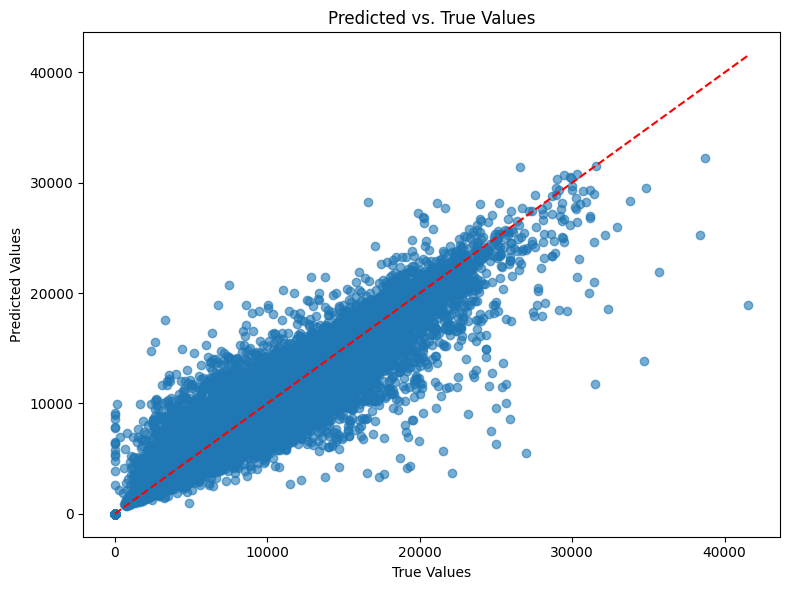

c:\Users\fikad\Desktop\DESKTOP\Rossmann-Pharmaceuticals-Sales-Prediction\scripts\ML_prediction.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=normalized_values, palette='viridis')


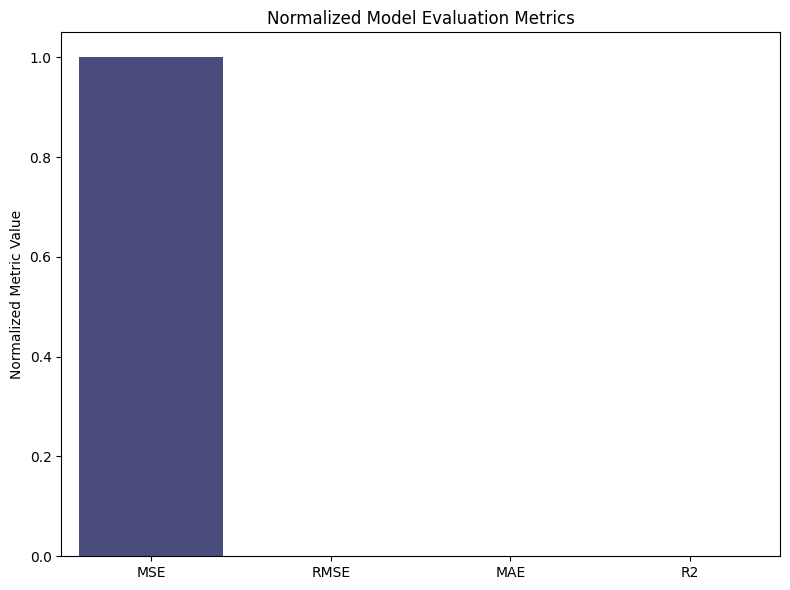

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('rf',
                  RandomForestRegressor(n_estimators=50, random_state=42))]),
 751307.1701509975,
 np.float64(866.7797702709711),
 499.5788586427582,
 0.9491975437745328)

In [7]:
builder.build_random_forest()

<style>
    h2 {
        color: #ffaa00;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h2>✨ Feature importance ✨</h2>


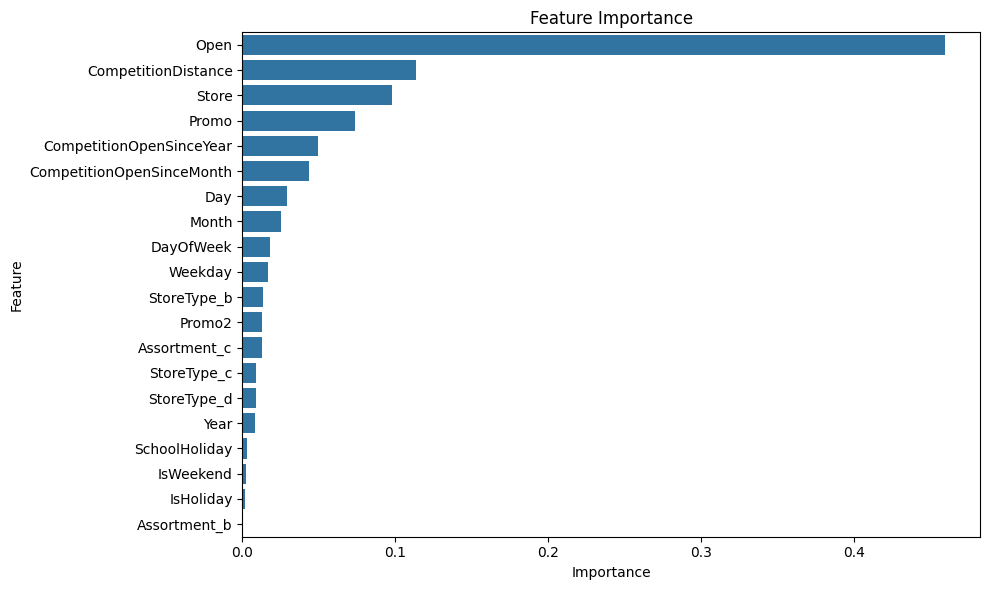

,Feature,Importance
2,Open,0.459673
5,CompetitionDistance,0.113439
0,Store,0.097585
3,Promo,0.073474
7,CompetitionOpenSinceYear,0.049162
6,CompetitionOpenSinceMonth,0.043354
11,Day,0.028987
12,Month,0.025542
1,DayOfWeek,0.018200
9,Weekday,0.016684


In [8]:
builder.feature_importance(plot=True)

<style>
    h1 {
        color: #aaee99;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h1>✨ Building model with deep learning ✨</h1>


In [ ]:
! pip install statsmodels

In [ ]:
! pip install statsmodels

In [ ]:
import statsmodels.api as sm
print(sm.__version__)  # Should print the version of statsmodels


<style>
    h2 {
        color: #ffaa00;
        text-shadow: 2px 2px 5px #000;
        font-family: "Comic Sans MS", sans-serif;
    }
</style>

<h2>✨ Model Training using LSTM ✨</h2>


In [9]:
from scripts.Deep_learning import LSTMModelBuilder

In [10]:
train['Date'] = pd.to_datetime(train['Date'])
train = train[['Date', 'Sales']]
train = train.set_index('Date')

In [11]:
lstm_model = LSTMModelBuilder(train)

In [12]:
lstm_model.check_stationarity()

Sampling 10000 points for stationarity test.
ADF Statistic: -99.8117180579864
p-value: 0.0
The data is stationary.


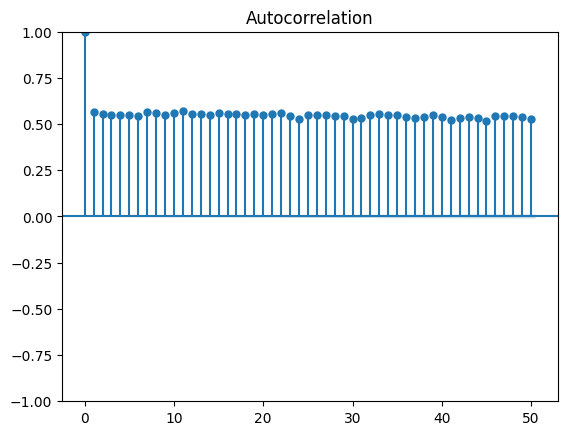

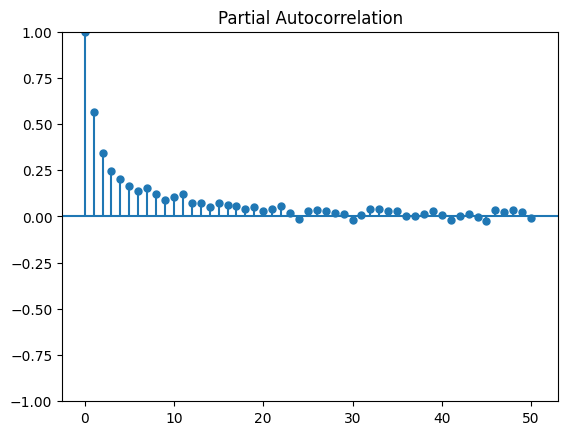

In [13]:
lstm_model.plot_acf_pacf()

In [14]:
X, y = lstm_model.create_supervised_data()

In [15]:
# Step 4: Scale the data
X_scaled, y_scaled = lstm_model.scale_data(X, y)

# Step 5: Split the data into train and test sets
X_train, X_test, y_train, y_test = lstm_model.split_data(X_scaled, y_scaled)

# Step 6: Build the LSTM model
model = lstm_model.build_lstm_model()

c:\Users\fikad\Desktop\DESKTOP\Rossmann-Pharmaceuticals-Sales-Prediction\Week-4\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Step 7: Train the model
model = lstm_model.train_model(model, X_train, y_train, X_test, y_test)
# Step 8: Plot the predictions
lstm_model.plot_predictions(model, X_test, y_test)

Epoch 1/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 232s 9ms/step - loss: 0.0180 - val_loss: 0.0162
Epoch 2/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 250s 10ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 3/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 298s 12ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 4/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 351s 14ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 5/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 673s 26ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 6/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 810s 32ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 7/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 893s 35ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 8/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 31148s 1s/step - loss: 0.0129 - val_loss: 0.0124
Epoch 9/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 214s 8ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 10/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 509s 20ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 11/50
25430/25430 ━━━━━━━━━━━━━━━━━━━━ 197s 8ms/step - loss: 0.01

AttributeError: 'tuple' object has no attribute 'predict'